In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', category=UserWarning)

from Processing.load_dataset import Load_dataset
from Processing.processing import Split, Valid, Submission
from Engineering.enginnering import engin
from Valid.validation import rmse

from Model.lightgbm import LightGBM
from Model.xgboost import XGBOOST
from Model.nn import NN
from sklearn.metrics import mean_squared_error

In [2]:
train, test = Load_dataset()

In [3]:
# 提出用
index = np.array(test["id"])

# 加工・処理
train_df = engin(train)
test_df = engin(test)

# val, train, test
X_train, X_test, y_train, y_test, index = Split(train_df)
X_train, X_valid, y_train, y_valid = Valid(X_train, y_train)

In [ ]:
predict = []
for contry in train['Country'].unique():
    df = train[(train['Country']==contry)]
    df = engin(df)
    X_train, X_test, y_train, y_test, index = Split(df)
    model = LightGBM(X_train, X_test, y_train, y_test, fig=1)
    
    df.drop(["pm25_mid"],axis=1, inplace=True)
    test_predict = model.predict(X_train)

    predict.append(test_predict)

In [68]:
predict = np.array(predict)

In [72]:
print(len(train))

195941
104
104


In [69]:
s=0
for i in range(len(predict)):
    s+= len(predict[i])
print(s)

156739


## NN

In [ ]:
# 学習
nn_model = NN(X_train, X_valid, y_train, y_valid, fig=1)

In [6]:
# 評価
test_predict = nn_model.predict(X_test)
rmse(test_predict, y_test)

RMSE:  22.203138629004858


In [45]:
# 予測
predict_nn = nn_model.predict(test_df)
# 提出
index = np.array(test["id"])
Submission(index, np.ravel(predict_nn), name='nn_2')

## light-gbm

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11474
[LightGBM] [Info] Number of data points in the train set: 125401, number of used features: 45
[LightGBM] [Info] Start training from score 59.230542
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	Train's rmse: 17.8239	Test's rmse: 20.7137


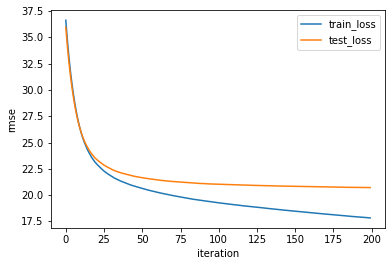

<BarContainer object of 20 artists>

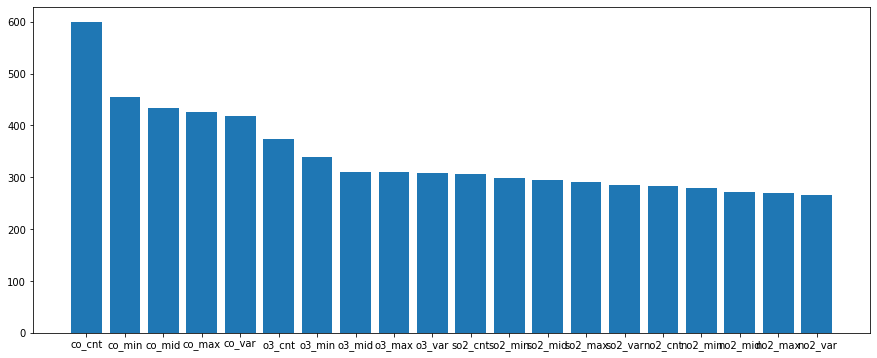

In [50]:
# 学習
Light_GBM = LightGBM(X_train, X_valid, y_train, y_valid, fig=1)
importance = pd.DataFrame(sorted(Light_GBM.feature_importance(), reverse=True), index=X_test.columns, columns=['importance'])
plt.figure(figsize=(15,6))
plt.bar(X_test.columns[:20], np.ravel(importance.values)[:20])

In [ ]:
# 評価
test_predict = Light_GBM.predict(X_test)
rmse(test_predict, y_test)

In [ ]:
# 予測
predict_light_gbm = Light_GBM.predict(data=test_df)

# 提出
Submission(index, predict_light_gbm, name='4')

## xgboost

In [ ]:
xgboost = XGBOOST(X_train, X_valid, y_train, y_valid, fig=1)

In [ ]:
importance = list(xgboost.get_score(importance_type='weight').values())
col = list(xgboost.get_score(importance_type='weight').keys())
plt.figure(figsize=(10,6))
plt.bar(col, importance)

In [ ]:
# 評価
import xgboost as xgb
dm_test = xgb.DMatrix(X_test)
test_predict = xgboost.predict(dm_test)
rmse(test_predict, y_test)

In [ ]:
# 予測
test = xgb.DMatrix(test_df)
predict_xgboost = xgboost.predict(test, ntree_limit=xgboost.best_ntree_limit)

Submission(index, predict_xgboost, name='xgb_1')